## Handling datasets with multiple modalities

In [1]:
%load_ext autotime

import scarf
scarf.__version__

'0.18.1'

time: 1.45 s (started: 2021-08-26 21:55:50 +02:00)


---
### 1) Fetch and convert data

For this tutorial we will use CITE-Seq data from 10x genomics. This dataset contains two modalities: gene expression and surface protein abundance. Throughout this tutorial we will refer to gene expression modality as `RNA` and surface protein as `ADT`. We start by downloading the data and converting it into Zarr format:

In [2]:
scarf.fetch_dataset(
    'tenx_8K_pbmc_citeseq',
    save_path='scarf_datasets'
)

time: 8.19 s (started: 2021-08-26 21:55:52 +02:00)


In [3]:
reader = scarf.CrH5Reader(
    'scarf_datasets/tenx_8K_pbmc_citeseq/data.h5'
)

time: 31 ms (started: 2021-08-26 21:56:00 +02:00)


We can also quickly check the different kinds of assays present in the file and the number of features from each of them.

In [4]:
reader.assayFeats

,RNA,ADT
type,Gene Expression,Antibody Capture
start,0,33538
end,33538,33555
nFeatures,33538,17


time: 0 ns (started: 2021-08-26 21:56:00 +02:00)


The **nFeatures** column shows the number of features present in each assay. `CrH5Reader` will automatically pull this information from H5 file and rename the 'Gene Expression' assay to **RNA**. Here it also found another assay: 'Antibody Capture' and named it to **assay2**. We will rename this to **ADT**.

In [5]:
reader.rename_assays({'assay2': 'ADT'})
reader.assayFeats

,RNA,ADT
type,Gene Expression,Antibody Capture
start,0,33538
end,33538,33555
nFeatures,33538,17


time: 0 ns (started: 2021-08-26 21:56:00 +02:00)


Now the data is converted into Zarr format. Like single assay datasets, all the data is saved under one Zarr file.

In [6]:
writer = scarf.CrToZarr(
    reader,
    zarr_fn='scarf_datasets/tenx_8K_pbmc_citeseq/data.zarr',
    chunk_size=(2000, 1000),
)
writer.dump(batch_size=1000)

  0%|                                                                                                         …

time: 6.7 s (started: 2021-08-26 21:56:00 +02:00)


---
### 2) Create a multimodal DataStore

The next step is to create a Scarf `DataStore` object. This object will be the primary way to interact with the data and all its constituent assays. The first time a Zarr file is loaded, we need to set the default assay. Here we set the 'RNA' assay as the default assay. When a Zarr file is loaded, Scarf checks if some per-cell statistics have been calculated. If not, then **nFeatures** (number of features per cell) and **nCounts** (total sum of feature counts per cell) are calculated. Scarf will also attempt to calculate the percent of mitochondrial and ribosomal content per cell.

In [7]:
ds = scarf.DataStore(
    'scarf_datasets/tenx_8K_pbmc_citeseq/data.zarr',
    default_assay='RNA',
    nthreads=4
)

(ADT) Computing nCells and dropOuts:   0%|                                                                    …

(RNA) Computing nCells and dropOuts:   0%|                                                                    …

(ADT) Computing nCounts:   0%|                                                                                …

(ADT) Computing nFeatures:   0%|                                                                              …

(RNA) Computing nCounts:   0%|                                                                                …

(RNA) Computing nFeatures:   0%|                                                                              …

(RNA) Computing RNA_percentMito:   0%|                                                                        …

(RNA) Computing RNA_percentRibo:   0%|                                                                        …

time: 3.09 s (started: 2021-08-26 21:56:07 +02:00)


We can print out the DataStore object to get an overview of all the assays stored.

In [8]:
ds

DataStore has 7865 (7865) cells with 2 assays: ADT RNA
   Cell metadata:
            'I', 'ids', 'names', 'ADT_nCounts', 'ADT_nFeatures', 
            'RNA_nCounts', 'RNA_nFeatures', 'RNA_percentMito', 'RNA_percentRibo'
   ADT assay has 17 (17) features and following metadata:
            'I', 'ids', 'names', 'dropOuts', 'nCells', 
          
   RNA assay has 13832 (33538) features and following metadata:
            'I', 'ids', 'names', 'dropOuts', 'nCells', 
          

time: 63 ms (started: 2021-08-26 21:56:10 +02:00)


Feature attribute tables for each of the assays can be accessed like this:

In [9]:
ds.RNA.feats.head()

,I,ids,names,dropOuts,nCells
0,False,ENSG00000243485,MIR1302-2HG,7865,0
1,False,ENSG00000237613,FAM138A,7865,0
2,False,ENSG00000186092,OR4F5,7865,0
3,False,ENSG00000238009,AL627309.1,7853,12
4,False,ENSG00000239945,AL627309.3,7865,0


time: 47 ms (started: 2021-08-26 21:56:10 +02:00)


In [10]:
ds.ADT.feats.head()

,I,ids,names,dropOuts,nCells
0,True,CD3,CD3_TotalSeqB,1,7864
1,True,CD4,CD4_TotalSeqB,1,7864
2,True,CD8a,CD8a_TotalSeqB,2,7863
3,True,CD14,CD14_TotalSeqB,1,7864
4,True,CD15,CD15_TotalSeqB,1,7864


time: 47 ms (started: 2021-08-26 21:56:10 +02:00)


Cell filtering is performed based on the default assay. Here we use the `auto_filter_cells` method of the `DataStore` to filter low quality cells.

INFO: 154 cells flagged for filtering out using attribute RNA_nCounts
INFO: 326 cells flagged for filtering out using attribute RNA_nFeatures
INFO: 119 cells flagged for filtering out using attribute RNA_percentMito
INFO: 21 cells flagged for filtering out using attribute RNA_percentRibo


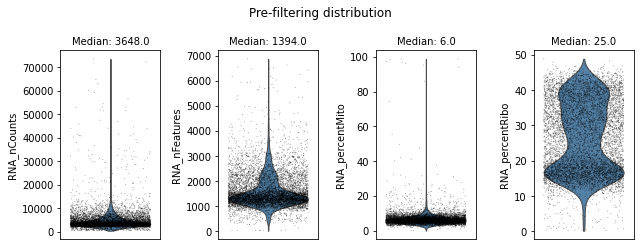

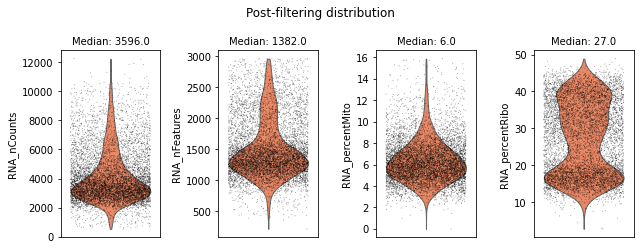

time: 1.83 s (started: 2021-08-26 21:56:10 +02:00)


In [11]:
ds.auto_filter_cells()

---
### 3) Process gene expression modality

Now we process the RNA assay to perform feature selection, create KNN graph, run UMAP reduction and clustering. These steps are same as shown in the basic workflow for scRNA-Seq data.

(RNA) Computing nCells:   0%|                                                                                 …

(RNA) Computing normed_tot:   0%|                                                                             …

(RNA) Computing sigmas:   0%|                                                                                 …

INFO: 997 genes marked as HVGs


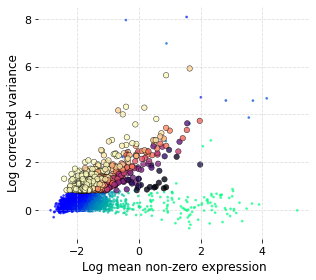

Normalizing with feature subset:   0%|                                                                        …

Writing data to normed__I__hvgs/data:   0%|                                                                   …

Calculating mean of norm. data:   0%|                                                                         …

Calculating std. dev. of norm. data:   0%|                                                                    …

Fitting PCA:   0%|                                                                                            …

Fitting ANN:   0%|                                                                                            …

Fitting kmeans:   0%|                                                                                         …

Estimating seed partitions:   0%|                                                                             …

Saving KNN graph:   0%|                                                                                       …

Smoothening KNN distances:   0%|                                                                              …

INFO: ANN recall: 99.99%
	completed  0  /  250 epochs
	completed  25  /  250 epochs
	completed  50  /  250 epochs
	completed  75  /  250 epochs
	completed  100  /  250 epochs
	completed  125  /  250 epochs
	completed  150  /  250 epochs
	completed  175  /  250 epochs
	completed  200  /  250 epochs
	completed  225  /  250 epochs
time: 22.8 s (started: 2021-08-26 21:56:12 +02:00)


In [12]:
ds.mark_hvgs(
    min_cells=20,
    top_n=1000,
    min_mean=-3,
    max_mean=2,
    max_var=6
)

ds.make_graph(
    feat_key='hvgs',
    k=21,
    dims=15,
    n_centroids=100
)

ds.run_umap(
    n_epochs=250,
    spread=5,
    min_dist=1,
    parallel=True
)

ds.run_leiden_clustering(resolution=1)

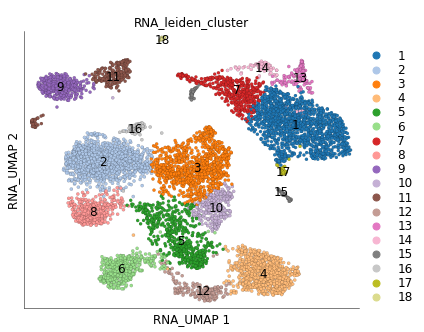

time: 500 ms (started: 2021-08-26 21:56:35 +02:00)


In [13]:
ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by='RNA_leiden_cluster',
    cmap='tab20'
)

---
### 4) Process protein surface abundance modality

We will now perform similar steps as RNA for the ADT data. Since ADT panels are often custom designed, we will not perform any feature selection step. This particular data contains some control antibodies which we should filter out before downstream analysis. 

In [14]:
ds.ADT.feats.head(n=ds.ADT.feats.N)

,I,ids,names,dropOuts,nCells
0,True,CD3,CD3_TotalSeqB,1,7864
1,True,CD4,CD4_TotalSeqB,1,7864
2,True,CD8a,CD8a_TotalSeqB,2,7863
3,True,CD14,CD14_TotalSeqB,1,7864
4,True,CD15,CD15_TotalSeqB,1,7864
5,True,CD16,CD16_TotalSeqB,1,7864
6,True,CD56,CD56_TotalSeqB,1,7864
7,True,CD19,CD19_TotalSeqB,163,7702
8,True,CD25,CD25_TotalSeqB,4,7861
9,True,CD45RA,CD45RA_TotalSeqB,1,7864


time: 16 ms (started: 2021-08-26 21:56:35 +02:00)


We can manually filter out the control antibodies by updating **I** to be False for those features. To do so we first extract the names of all the ADT features like below:

In [15]:
adt_names = ds.ADT.feats.to_pandas_dataframe(['names'])['names']
adt_names

0               CD3_TotalSeqB
1               CD4_TotalSeqB
2              CD8a_TotalSeqB
3              CD14_TotalSeqB
4              CD15_TotalSeqB
5              CD16_TotalSeqB
6              CD56_TotalSeqB
7              CD19_TotalSeqB
8              CD25_TotalSeqB
9            CD45RA_TotalSeqB
10           CD45RO_TotalSeqB
11             PD-1_TotalSeqB
12            TIGIT_TotalSeqB
13            CD127_TotalSeqB
14    IgG2a_control_TotalSeqB
15     IgG1_control_TotalSeqB
16    IgG2b_control_TotalSeqB
Name: names, dtype: object

time: 16 ms (started: 2021-08-26 21:56:35 +02:00)


The ADT features with 'control' in name are designated as control antibodies. You can have your own selection criteria here. The aim here is to create a boolean array that has `True` value for features to be removed.

In [16]:
is_control = adt_names.str.contains('control').values
is_control

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True])

time: 0 ns (started: 2021-08-26 21:56:35 +02:00)


Now we update `I` to remove the control features. `update_key` method takes a boolean array and disables the features that have `False` value. So we invert the above created array (using `~`) before providing it to `update_key`. The second parameter for `update_key` denotes which feature table boolean column to modify, `I` in this case.

In [17]:
ds.ADT.feats.update_key(~is_control, 'I')
ds.ADT.feats.head(n=ds.ADT.feats.N)

,I,ids,names,dropOuts,nCells
0,True,CD3,CD3_TotalSeqB,1,7864
1,True,CD4,CD4_TotalSeqB,1,7864
2,True,CD8a,CD8a_TotalSeqB,2,7863
3,True,CD14,CD14_TotalSeqB,1,7864
4,True,CD15,CD15_TotalSeqB,1,7864
5,True,CD16,CD16_TotalSeqB,1,7864
6,True,CD56,CD56_TotalSeqB,1,7864
7,True,CD19,CD19_TotalSeqB,163,7702
8,True,CD25,CD25_TotalSeqB,4,7861
9,True,CD45RA,CD45RA_TotalSeqB,1,7864


time: 31 ms (started: 2021-08-26 21:56:35 +02:00)


Assays named ADT are automatically created as objects of the `ADTassay` class, which uses CLR (centred log ratio) normalization as the default normalization method.

In [18]:
print (ds.ADT)
print (ds.ADT.normMethod.__name__)

ADTassay ADT with 14(17) features
norm_clr
time: 0 ns (started: 2021-08-26 21:56:35 +02:00)


Now we are ready to create a KNN graph of cells using only ADT data. Here we will use all the features (except those that were filtered out) and that is why we use `I` as value for `feat_key`. It is important to note the value for `from_assay` parameter which has now been set to `ADT`. If no value is provided for `from_assay` then it is automatically set to the default assay. By setting `dims` to 0 we disable dimension reduction.

In [19]:
ds.make_graph(
    from_assay='ADT',
    feat_key='I', 
    k=21,
    dims=0,
    n_centroids=100
)

Writing data to normed__I__I/data:   0%|                                                                      …

Calculating mean of norm. data:   0%|                                                                         …

Calculating std. dev. of norm. data:   0%|                                                                    …

Fitting ANN:   0%|                                                                                            …

Fitting kmeans:   0%|                                                                                         …

Estimating seed partitions:   0%|                                                                             …

Saving KNN graph:   0%|                                                                                       …

Smoothening KNN distances:   0%|                                                                              …

INFO: ANN recall: 99.96%
time: 2.62 s (started: 2021-08-26 21:56:35 +02:00)


UMAP and clustering can be run on ADT assay by simply setting `from_assay` parameter value to 'ADT':

In [20]:
ds.run_umap(
    from_assay='ADT',
    n_epochs=250,
    spread=5,
    min_dist=1,
    parallel=True
)

ds.run_leiden_clustering(
    from_assay='ADT',
    resolution=1
)

	completed  0  /  250 epochs
	completed  25  /  250 epochs
	completed  50  /  250 epochs
	completed  75  /  250 epochs
	completed  100  /  250 epochs
	completed  125  /  250 epochs
	completed  150  /  250 epochs
	completed  175  /  250 epochs
	completed  200  /  250 epochs
	completed  225  /  250 epochs
time: 5.83 s (started: 2021-08-26 21:56:38 +02:00)


If we now check the cell attribute table, we will find the UMAP coordinates and clusters calculated using `ADT` assay:

In [21]:
ds.cells.head()

,I,ids,names,ADT_UMAP1,ADT_UMAP2,ADT_leiden_cluster,ADT_nCounts,ADT_nFeatures,RNA_UMAP1,RNA_UMAP2,RNA_leiden_cluster,RNA_nCounts,RNA_nFeatures,RNA_percentMito,RNA_percentRibo
0,True,AAACCCAAGATTGTGA-1,AAACCCAAGATTGTGA-1,-20.397385,13.901927,5,981.0,17.0,30.417028,9.842134,1,6160.0,2194.0,8.668831,15.259740
1,True,AAACCCACATCGGTTA-1,AAACCCACATCGGTTA-1,-7.246043,20.109583,5,1475.0,17.0,28.401850,6.947437,1,6713.0,2093.0,6.316103,19.037688
2,True,AAACCCAGTACCGCGT-1,AAACCCAGTACCGCGT-1,-11.792799,20.727037,5,7149.0,17.0,15.991136,9.329577,1,3637.0,1518.0,8.056090,16.002200
3,True,AAACCCAGTATCGAAA-1,AAACCCAGTATCGAAA-1,21.236305,17.124186,3,6831.0,17.0,18.031033,-24.243393,4,1244.0,737.0,9.003215,18.729904
4,True,AAACCCAGTCGTCATA-1,AAACCCAGTCGTCATA-1,22.536177,14.695609,3,6839.0,17.0,14.805031,-29.158672,4,2611.0,1240.0,6.204519,16.353887


time: 47 ms (started: 2021-08-26 21:56:44 +02:00)


Visualizing the UMAP and clustering calcualted using `ADT` only:

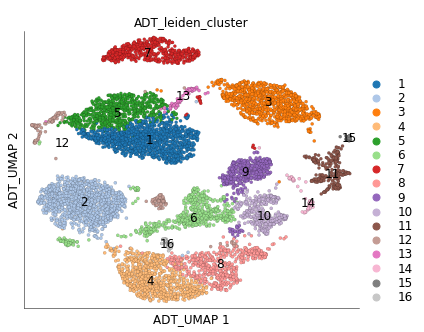

time: 485 ms (started: 2021-08-26 21:56:44 +02:00)


In [22]:
ds.plot_layout(
    layout_key='ADT_UMAP',
    color_by='ADT_leiden_cluster',
    cmap='tab20'
)

---
### 5) Cross modality comparison

It is generally of interest to see how different modalities corroborate each other.

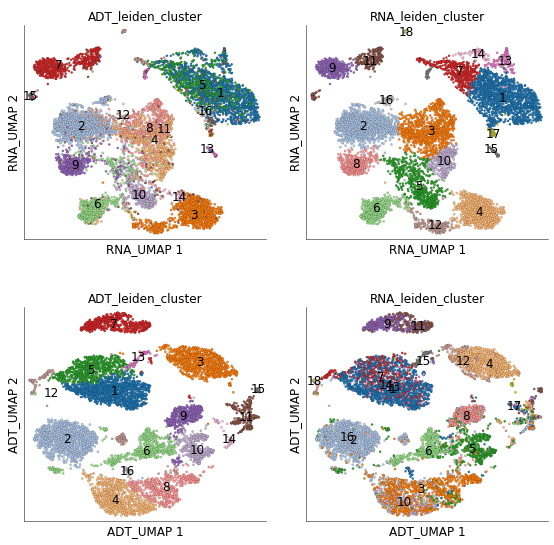

time: 937 ms (started: 2021-08-26 21:56:44 +02:00)


In [23]:
# UMAP on RNA and coloured with clusters calculated on ADT
ds.plot_layout(
    layout_key=['RNA_UMAP', 'ADT_UMAP'],
    color_by=['ADT_leiden_cluster', 'RNA_leiden_cluster'],
    cmap='tab20',
    width=4,
    height=4, 
    n_columns=2,
    point_size=5,
    legend_onside=False
)

We can quantify the overlap of cells between RNA and ADT clusters. The following table has ADT clusters on columns and RNA clusters on rows. This table shows a cross tabulation of cells across the clustering from the two modalities.

In [24]:
import pandas as pd

df = pd.crosstab(
    ds.cells.fetch('RNA_leiden_cluster'),
    ds.cells.fetch('ADT_leiden_cluster')
)
df

col_0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
row_0,,,,,,,,,,,,,,,,
1,832,0,0,4,361,15,2,10,1,2,53,1,0,0,0,25
2,0,981,0,51,1,12,0,27,27,1,14,52,0,0,0,0
3,0,20,0,423,0,14,0,400,9,9,23,19,0,0,0,0
4,0,0,725,0,0,0,0,1,0,1,31,0,0,33,0,0
5,0,19,3,7,0,111,0,57,51,295,29,1,0,9,0,0
6,0,0,0,23,0,407,0,2,6,3,14,1,0,2,0,0
7,154,0,2,0,191,0,0,0,0,0,9,32,5,0,0,2
8,0,8,0,0,0,18,0,1,340,2,4,8,0,0,0,0
9,0,0,0,0,0,0,324,0,0,0,8,0,0,0,0,0


time: 31 ms (started: 2021-08-26 21:56:45 +02:00)


There are possibly many interesting strategies to analyze this further. One simple way to summarize the above table can be quantify the transcriptomics 'purity' of ADT clusters:

In [25]:
(100 * df.max()/df.sum()).sort_values(ascending=False)

col_0
15    100.000000
10     92.187500
2      91.001855
16     89.285714
13     86.956522
3      81.644144
9      76.923077
8      76.628352
1      75.705187
6      68.634064
14     66.000000
7      61.832061
5      58.699187
4      57.085020
12     34.899329
11     21.115538
dtype: float64

time: 0 ns (started: 2021-08-26 21:56:45 +02:00)


Individual ADT expression can be visualized in both UMAPs easily.

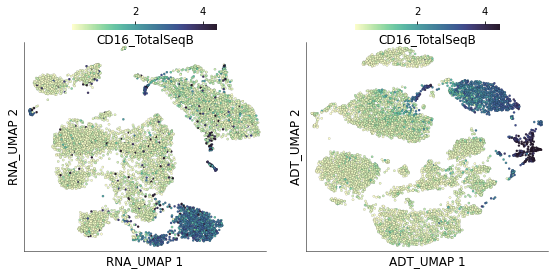

time: 1.3 s (started: 2021-08-26 21:56:45 +02:00)


In [26]:
ds.plot_layout(
    layout_key=['RNA_UMAP', 'ADT_UMAP'],
    color_by='CD16_TotalSeqB',
    from_assay='ADT',
    width=4,
    height=4,
    n_columns=2,
    point_size=5
)

We can also query gene expression and visualize it on both RNA and ADT UMAPs. Here we query gene FCGR3A which codes for CD16:

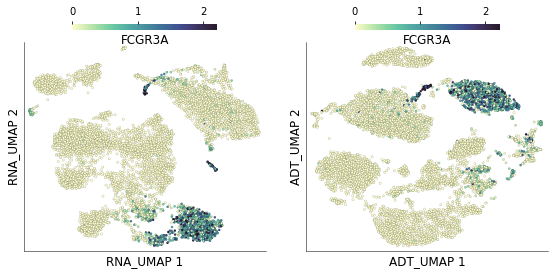

time: 1.42 s (started: 2021-08-26 21:56:47 +02:00)


In [27]:
ds.plot_layout(
    layout_key=['RNA_UMAP', 'ADT_UMAP'],
    color_by='FCGR3A',
    from_assay='RNA',
    width=4,
    height=4,
    n_columns=2,
    point_size=5
)

---
### 6) Integration of modalities

The KNN graphs created individually for each of the modalities can be merged together to provide an integrated mutimodal view of the data. Scarf takes the latest KNN graphs (continous form edge weight) generated for each of the user chosen modality and merges the edges from each modality. After first round of merging, Scarf performs edge pruning by penalizing those edges more that have lower number of shared nearest neighbors between the connected cells. For each cells edges are pruned until the same number of edges as in individual modalities' KNN graphs are left.

Here we will integrate the *RNA* and *ADT* assays and run UMAP and leiden clustering on the integrated graph.

In [28]:
ds.integrate_assays(
    assays=['RNA', 'ADT'],
    label='RNA+ADT'
)

Identifying SNNs in graphs:   0%|                                                                             …

Merging graph edges:   0%|                                                                                    …

time: 5.42 s (started: 2021-08-26 21:56:48 +02:00)


`integrated_graph` parameter in `run_umap` and `run_leiden_clustering` allows running these steps on the integrated graph.

In [29]:
ds.run_umap(
    integrated_graph='RNA+ADT',
    n_epochs=500,
    spread=5,
    min_dist=0.5,
    parallel=True
)

ds.run_leiden_clustering(
    integrated_graph='RNA+ADT',
    resolution=1.75
)

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
time: 11.6 s (started: 2021-08-26 21:56:53 +02:00)


Lets visualize the UMAPs created using the integrated manifolds from the two modalities. Here we label the cells based on their modality specific cluster identity as well as integrated manifold cluster identity

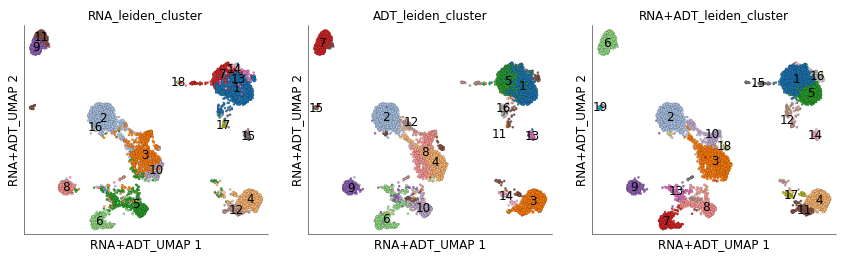

time: 734 ms (started: 2021-08-26 21:57:05 +02:00)


In [30]:
ds.plot_layout(
    layout_key=['RNA+ADT_UMAP'],
    color_by=['RNA_leiden_cluster',
              'ADT_leiden_cluster',
              'RNA+ADT_leiden_cluster'],
    cmap='tab20',
    legend_onside=False,
    point_size=5,
    width=4,
    height=4,
    n_columns=3
)

In [31]:
ds.cells.columns

['I',
 'ids',
 'names',
 'ADT_UMAP1',
 'ADT_UMAP2',
 'ADT_leiden_cluster',
 'ADT_nCounts',
 'ADT_nFeatures',
 'RNA+ADT_UMAP1',
 'RNA+ADT_UMAP2',
 'RNA+ADT_leiden_cluster',
 'RNA_UMAP1',
 'RNA_UMAP2',
 'RNA_leiden_cluster',
 'RNA_nCounts',
 'RNA_nFeatures',
 'RNA_percentMito',
 'RNA_percentRibo']

time: 0 ns (started: 2021-08-26 21:57:06 +02:00)


The UMAP and clustering calculated on the integrated graph are here saved under cell attribute table with prefix *RNA+ADT*

---
That is all for this vignette.